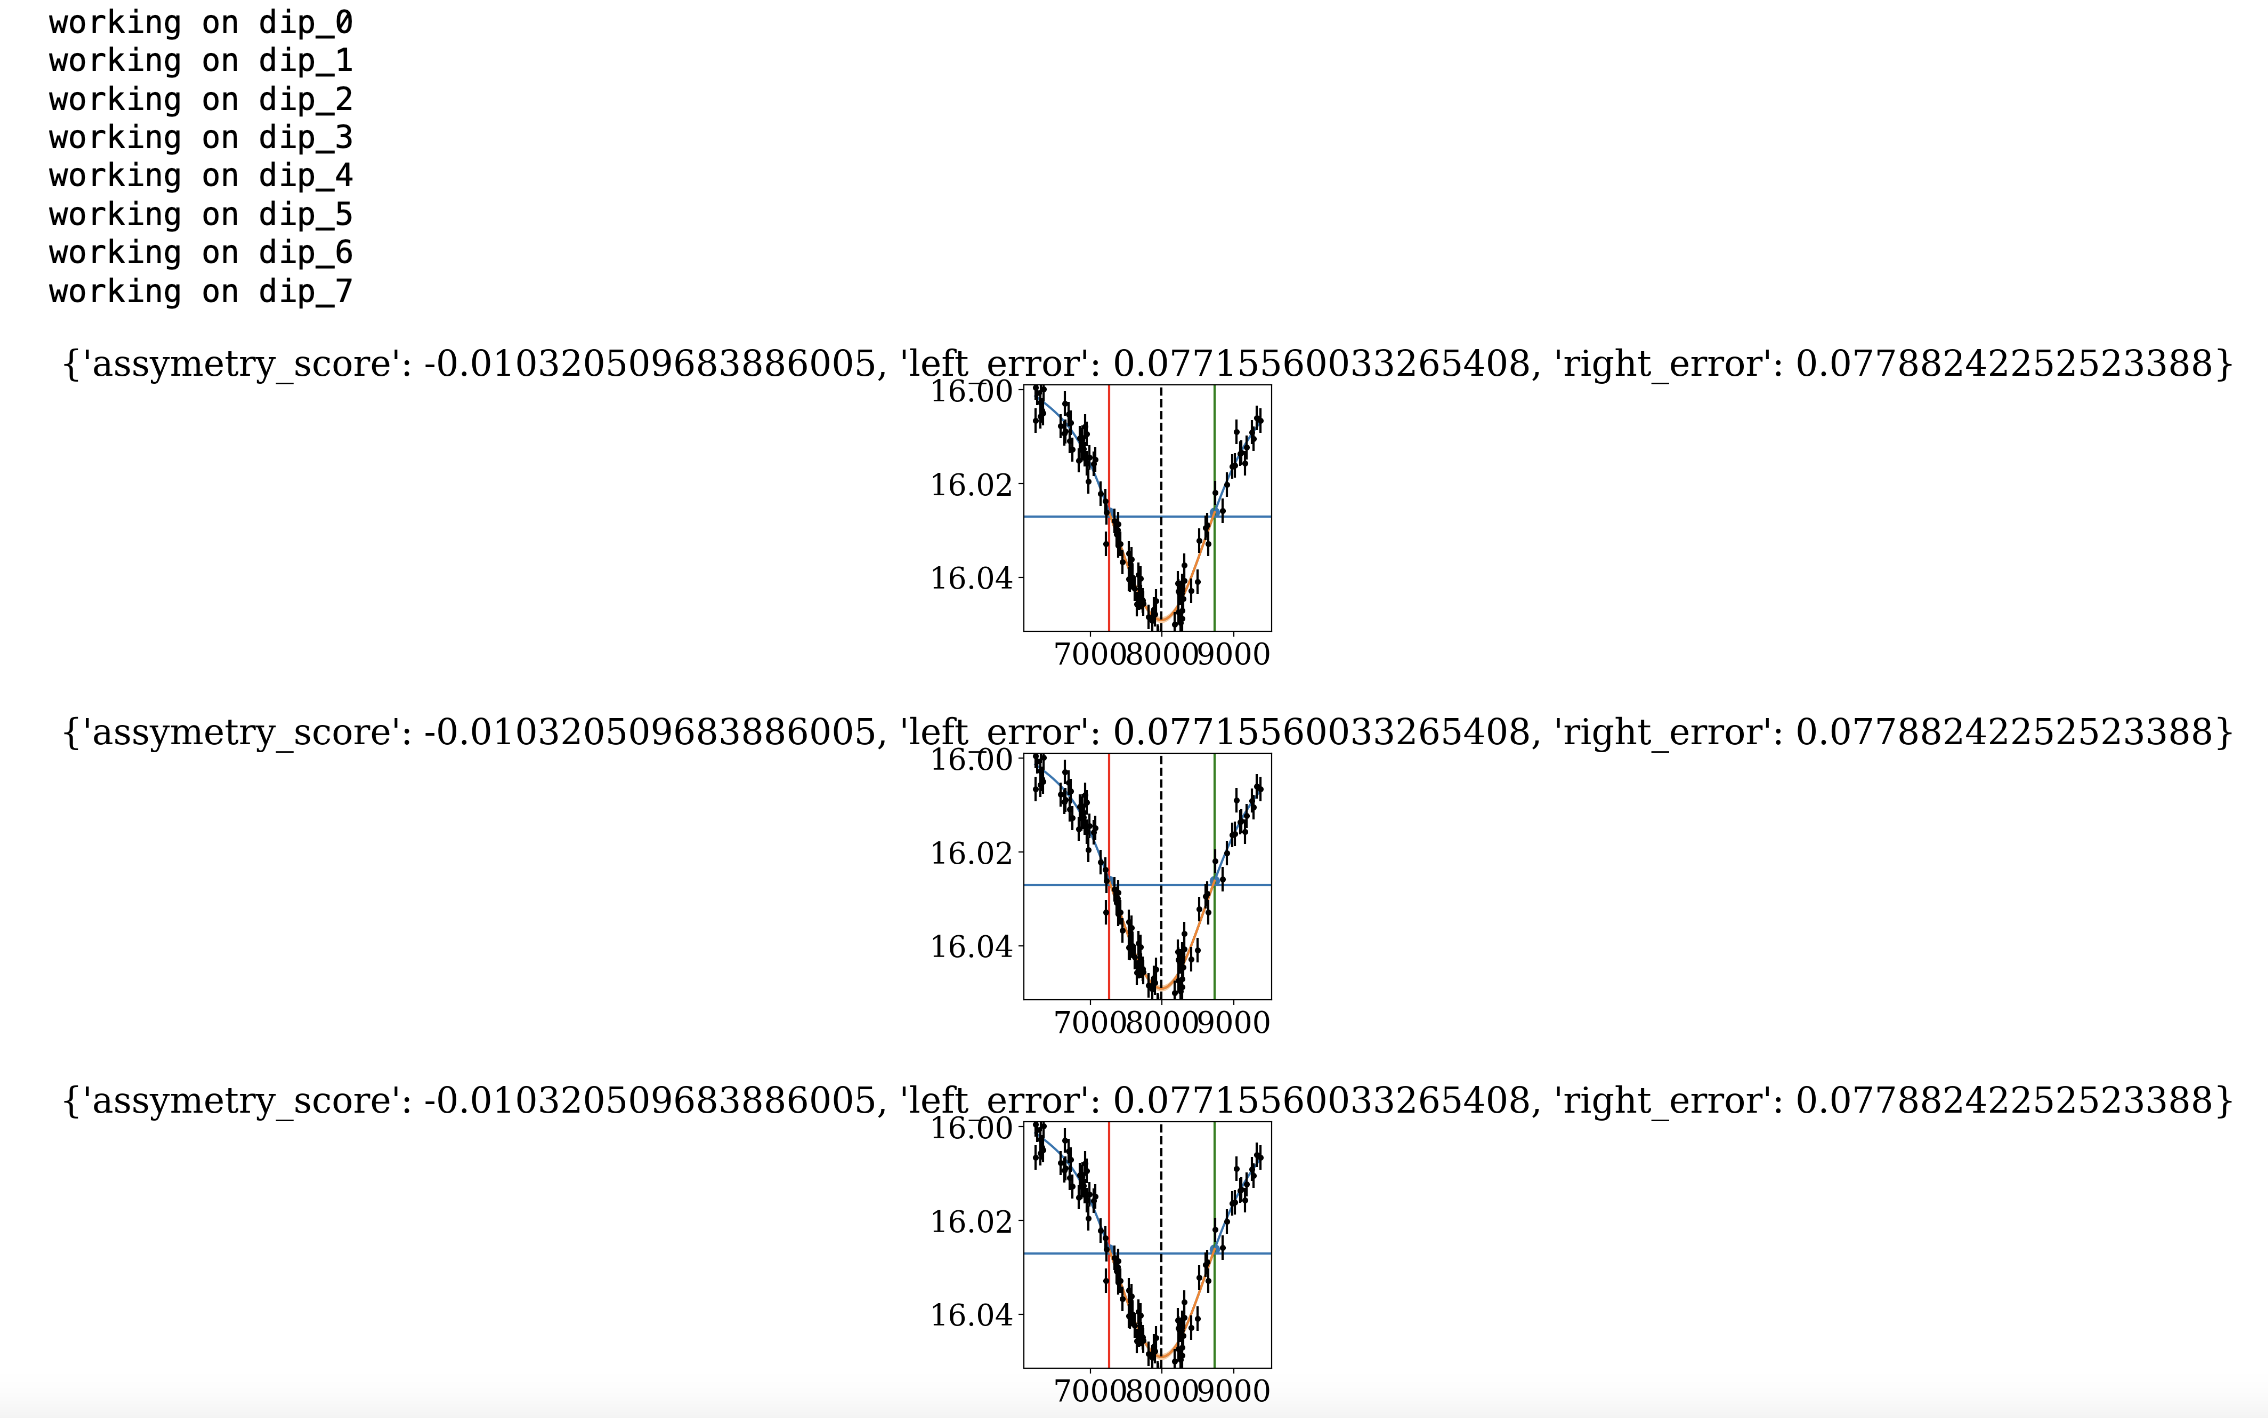

In previous versios of the dip code we inject a single dimming evenf for the light curve - however our summary code is identifying multiple peaks in the valley. We want to figure out a work around solution such that it's not **always** stuck in the valley (unless there's legitimate  sub-structure inside).

In [12]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
from scipy import interpolate
import astropy.stats as astro_stats
from scipy.optimize import curve_fit
from astropy.io import ascii
from scipy.signal import find_peaks
import scipy.integrate as integrate

### Generate Synthetic Data

In [112]:
N = 350 # number of detections
time = np.random.randint(100, 10_000, N) + np.random.normal(1, 1150, N) + np.random.uniform(0, 1, N)
ts = np.argsort(time)
time = time[ts]

line = lambda x, a, b: x*a + b
dip = lambda x, a, b, c: a*np.exp(-((x-b)**2)/(2*c**2))

mr = np.zeros(N) + 16 + np.random.normal(0, 0.03, N) + dip(time, 0.5, 5_000, 450)
mr_err = line(mr, 0.001, 1e-3)

(16.57254715302668, 15.872842136749293)

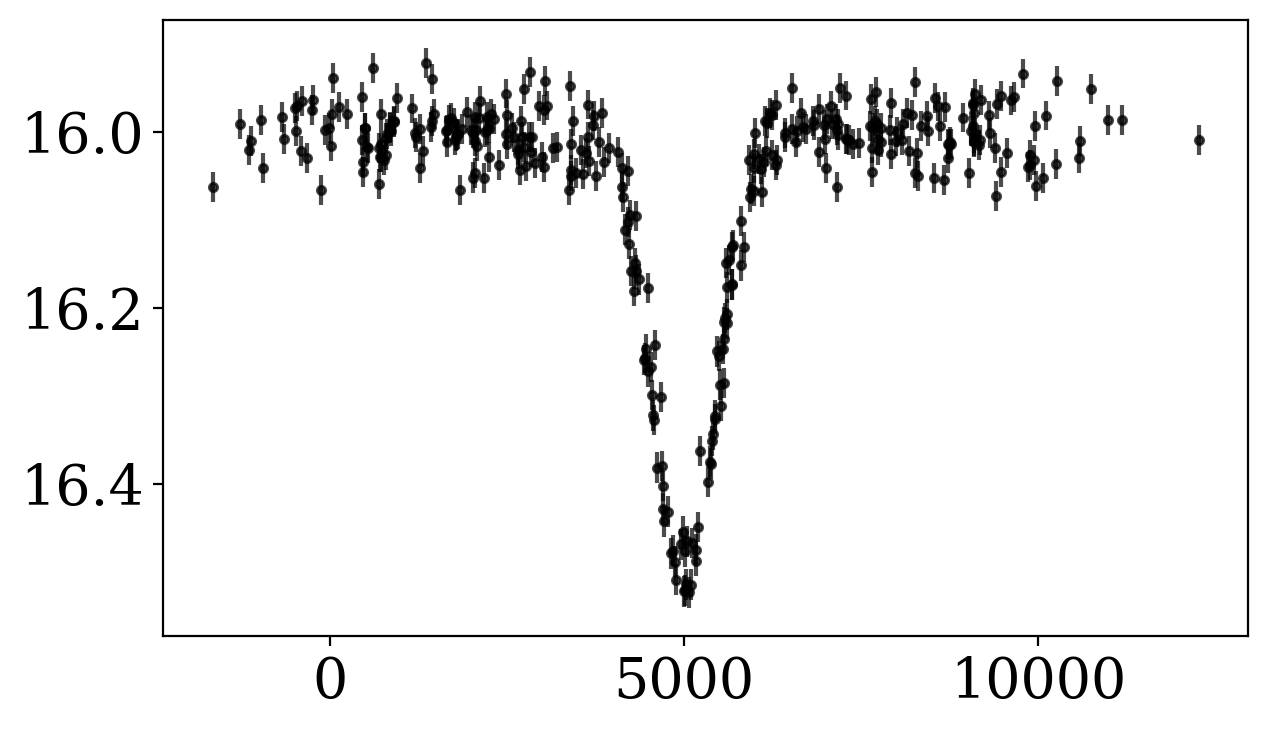

In [113]:
plt.figure(figsize=(7, 4))
plt.errorbar(time, mr, mr_err, fmt='.', color='k', alpha=0.7)
plt.ylim(plt.ylim()[::-1])

In [114]:
def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)


def variation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag_err), astro_stats.biweight_scale(mag_err)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)    


def calc_dip_edges(xx, yy, _cent, atol=0.2):
    """Crude estimation of the edges of a dipper given the centroid. 
    
      Parameters
      ----------
      xx (array-like): time axis
      yy (array-like): dev
      _cent (float): centroid time 
      atol (float): tolerance to the median. Default is 0.2
    """
    
    indices_forward = np.where((xx > _cent) & np.isclose(yy, np.median(yy), atol=atol))[0]
    t_forward = xx[indices_forward[0]] if indices_forward.size > 0 else 0
    
    indices_back = np.where((xx < _cent) & np.isclose(yy, np.median(yy), atol=atol))[0]
    if indices_back.size > 0:
        t_back = xx[indices_back[-1]]
    else:
        t_back = 0
        
    # Diagnostics numbers
    
    # How many detections above the median thresh in the given window?
    _window_ = (xx>t_back) & (xx<t_forward)
    sel_1_sig = (yy[_window_]>np.median(yy) + np.std(yy)) # detections above 1 sigma
    N_thresh_1 = len((yy[_window_])[sel_1_sig])
    
    return t_forward, t_back, (t_forward-_cent), N_thresh_1


def summarize_dev_dips(times, dips, power_thresh=3, loc_peak_thresh=6, peak_close_rmv=15):
    
    # Scipy peak finding algorithm
    pks, _ = find_peaks(dips, height=loc_peak_thresh)
    pks = np.sort(pks)[::-1] # sort the reverse peaks
    
    print ('peaks identified', pks)
    
    # Time of peaks and dev of peaks
    t_pks, p_pks = times[pks], dips[pks]
    
    # TODO: we need to figure out how to remove multiple peaks that are stacked to each other...
    
    
    # remove peaks that are too close to each other
    #t_pks = np.array([t_pks[i] for i in range(0, len(t_pks)-1) if ~np.isclose(t_pks[i],
    #                                                                     t_pks[i+1],
    #                                                                     atol=peak_close_rmv)]) # 5 day tolerance window...
    
    #p_pks = np.array([p_pks[i] for i in range(0, len(t_pks)-1) if ~np.isclose(t_pks[i],
    #                                                                    t_pks[i+1],
    #                                                                    atol=peak_close_rmv)])
    srt = np.argsort(t_pks) # argsort the t_pks
    
    t_pks, p_pks = t_pks[srt], p_pks[srt] # rename variables...
    
    print ('peak params', t_pks, p_pks)
    
    
    N_peaks = len(t_pks) # number of peaks with removed
    
    # summarize peak information
    dip_summary = {}
    
    i = 0
    for time_ppk, ppk in zip(t_pks, p_pks):
        _edges = calc_dip_edges(times, dips, time_ppk, atol=0.2)
        
        dip_summary[f'dip_{i}'] = {
            "peak_loc": time_ppk,
            'window_start': _edges[0],
            'window_end': _edges[1],
            "N_1sig_in_dip": _edges[-1], 
            'loc_forward_dur': _edges[2],
            "dip_power":ppk
        }
        
        i+=1
    
    return N_peaks, dip_summary

In [115]:
summarize_dev_dips(time, deviation(mr, mr_err)) # problem...

peaks identified [199 191 189 185 182 179 177 174 171 169 167 164 162]
peak params [4575.61815917 4623.22463541 4695.05086407 4712.22842586 4815.31993135
 4887.7879584  4992.54365871 5016.3978151  5066.81887448 5161.86327847
 5335.74116931 5375.9051849  5525.30026669] [ 6.61279504  7.73233509  8.69792018  8.99365042  9.73910656 10.35067751
 10.62586335 10.60456291 10.65228908  9.90912946  8.07210061  7.63716461
  6.28522128]


(13,
 {'dip_0': {'peak_loc': 4575.6181591695,
   'window_start': 6161.873807279428,
   'window_end': 3944.868689167245,
   'N_1sig_in_dip': 61,
   'loc_forward_dur': 1586.2556481099273,
   'dip_power': 6.61279503841383},
  'dip_1': {'peak_loc': 4623.224635412722,
   'window_start': 6161.873807279428,
   'window_end': 3944.868689167245,
   'N_1sig_in_dip': 61,
   'loc_forward_dur': 1538.6491718667057,
   'dip_power': 7.732335087981699},
  'dip_2': {'peak_loc': 4695.050864069859,
   'window_start': 6161.873807279428,
   'window_end': 3944.868689167245,
   'N_1sig_in_dip': 61,
   'loc_forward_dur': 1466.8229432095686,
   'dip_power': 8.697920183536473},
  'dip_3': {'peak_loc': 4712.228425863284,
   'window_start': 6161.873807279428,
   'window_end': 3944.868689167245,
   'N_1sig_in_dip': 61,
   'loc_forward_dur': 1449.6453814161432,
   'dip_power': 8.99365042021165},
  'dip_4': {'peak_loc': 4815.319931350725,
   'window_start': 6161.873807279428,
   'window_end': 3944.868689167245,
   'N_

In [194]:
dev = deviation(mr, mr_err)

# dev needs to be smoothed! 
from scipy.signal import savgol_filter

In [195]:
yhat = savgol_filter(dev, 51, 3)

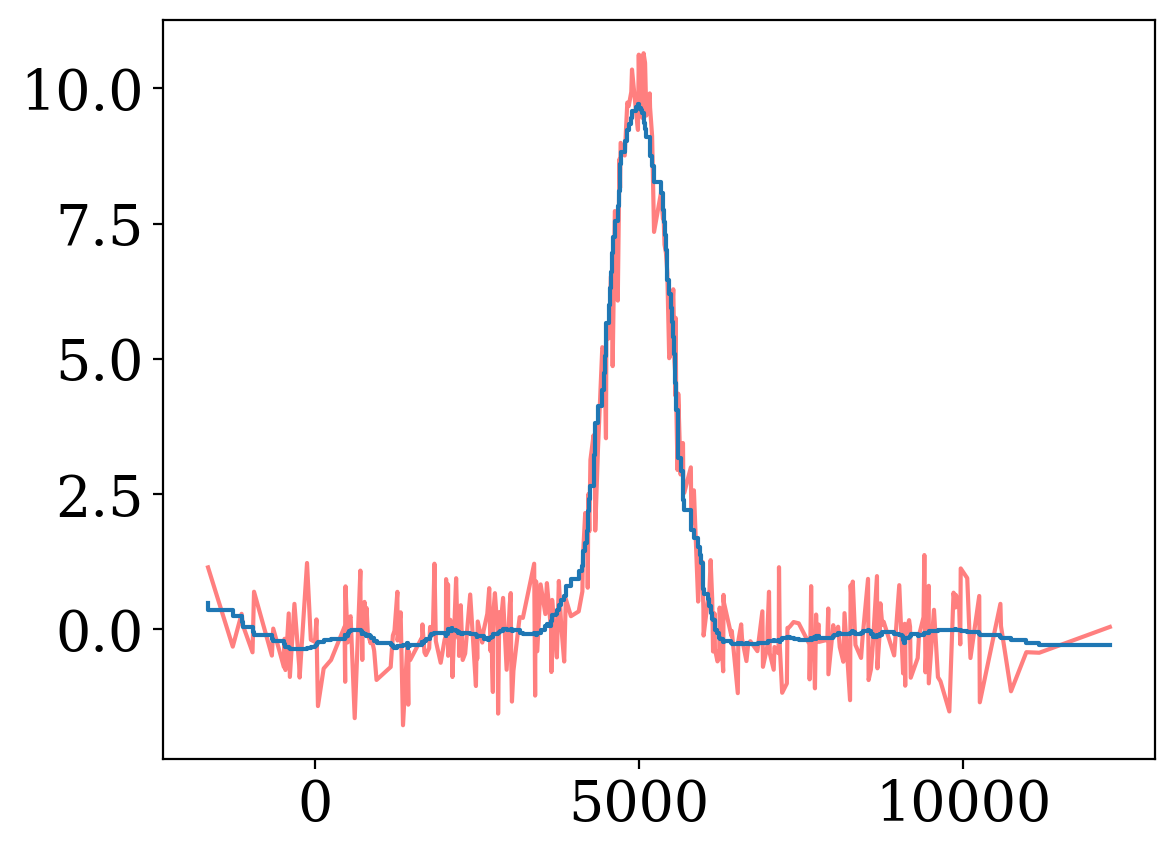

In [196]:

plt.plot(time, dev, alpha=0.5, color='red')
plt.step(time, yhat)



In [184]:
pks, _ = find_peaks(yhat, height=6)

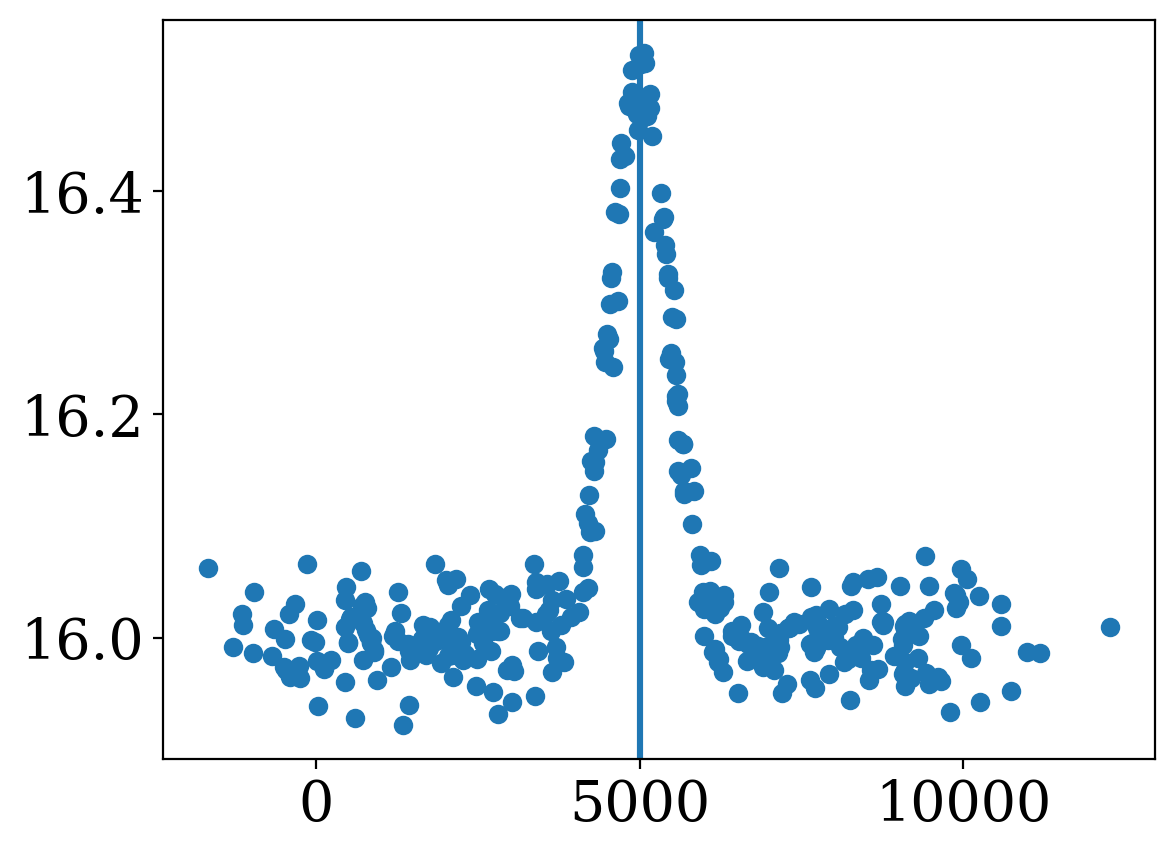

In [185]:
plt.scatter(time, mr)
for j in pks:
    plt.axvline(time[j])

In [197]:
lc_new = ascii.read("https://ztf.snad.space/dr17/csv/802211300046586")

In [199]:
dv1 = deviation(lc_new['mag'], lc_new['magerr'])

In [213]:
yy = savgol_filter(dv1, 21, 8)

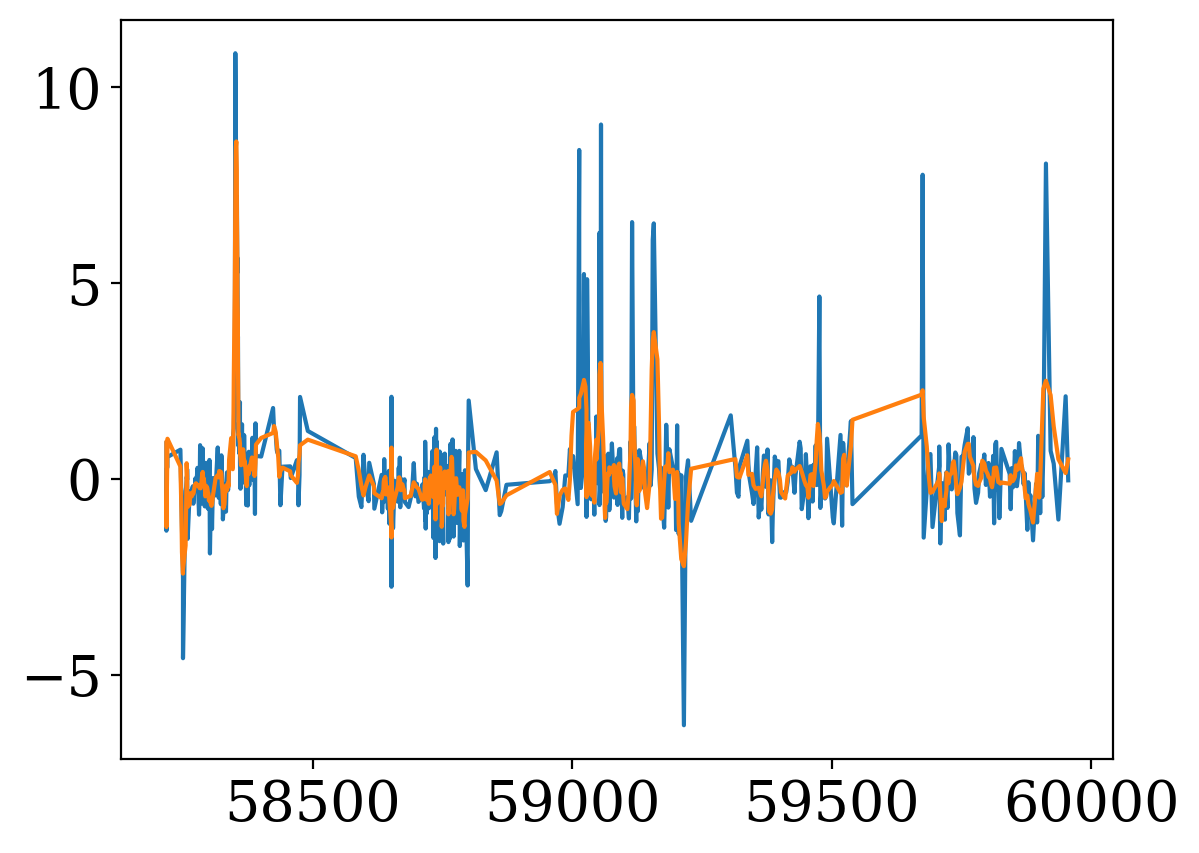

In [214]:
plt.plot(lc_new['mjd'], dv1)
plt.plot(lc_new['mjd'], yy)
